In [373]:
OPTIONS={
    'train_split_percentage': 0.75,
    'valid_split_percentage': 0.15,
    'test_split_percentage': 0.1,
    'batch_size': 32,
    'random_seed': 1738,
    'num_epochs': 25,
    'learning_rate': 1e-5,
    'l2_penalty': 1e-4
}

In [375]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import List
from tqdm import tqdm
from neattime import neattime

sns.set_style('darkgrid')

In [376]:
OPTIONS['model_dir'] = f'models_{neattime()}'

os.makedirs(OPTIONS['model_dir'], exist_ok=True)

print(f"Models will be saved to: {OPTIONS['model_dir']}")

Models will be saved to: models_2025-04-09_22-17-15_313259


In [377]:
# set random seed. Not guaranteed to be reprducible anyways tho
torch.manual_seed(OPTIONS['random_seed'])

# Visualizing Data

In [378]:
# get directory name(s)
data_directory = 'data'
data_subdirects = [f.path for f in os.scandir(data_directory) if f.is_dir()]
data_subdirects

['data/Basophil',
 'data/Neutrophil',
 'data/Monocyte',
 'data/Eosinophil',
 'data/Lymphocyte']

In [379]:
# obtaining the total number of images for each cell type
totals = {}
for directory in data_subdirects:
    label = directory.split('/')[-1]  # 'basophil', 'neutrophil', etc.
    totals[label] = len(os.listdir(directory))

In [380]:
totals

{'Basophil': 301,
 'Neutrophil': 10862,
 'Monocyte': 795,
 'Eosinophil': 1066,
 'Lymphocyte': 3609}

In [381]:
"Total number of images: " + str(sum(totals.values()))

'Total number of images: 16633'

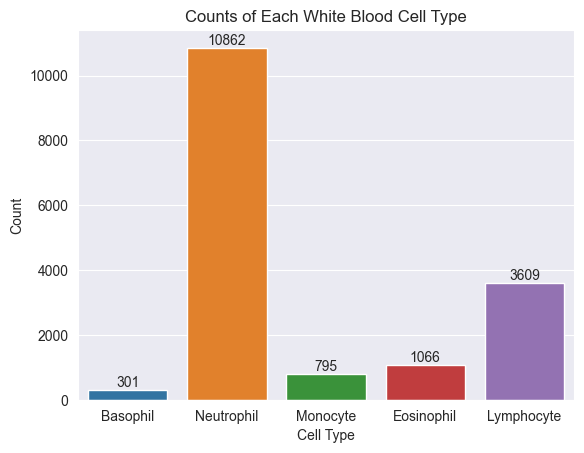

In [382]:
ax = sns.barplot(x = list(totals.keys()), y = totals.values(), hue = list(totals.keys()))
plt.title('Counts of Each White Blood Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Count')

for container in ax.containers:
    ax.bar_label(container)

In [383]:
# for viewing images
import matplotlib.image as mpimg
import random

Cell Type: Basophil


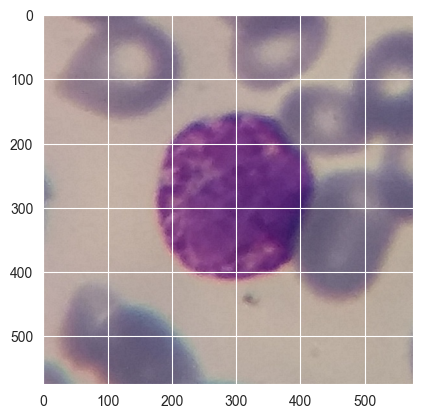

Cell Type: Neutrophil


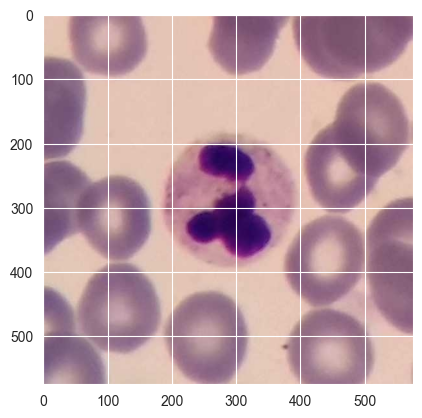

Cell Type: Monocyte


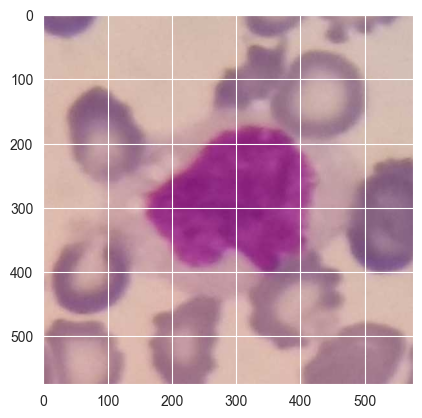

Cell Type: Eosinophil


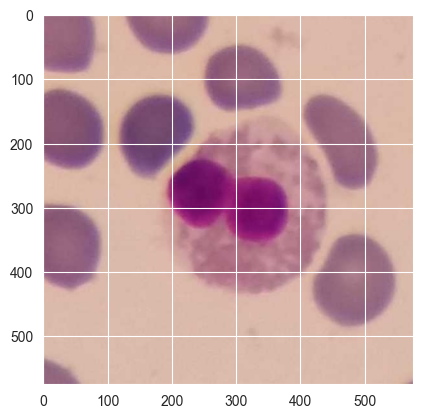

Cell Type: Lymphocyte


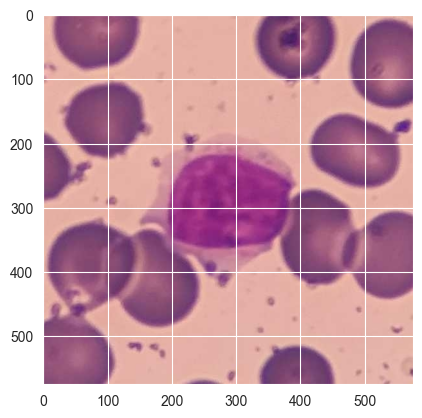

In [384]:
# viewing a random image from each of the 5 categories
for directory in data_subdirects:  
    all_category_paths = os.listdir(directory)  # list of paths to all images in category
    random_image_path = os.path.join(directory, random.choice(all_category_paths))
    label = directory.split('/')[-1]
    print(f"Cell Type: {label}")
    img = mpimg.imread(random_image_path)
    imgplot = plt.imshow(img)
    plt.show()

# Building Datasets and DataLoaders

In [385]:
from torch.utils.data import Dataset, DataLoader  # map-style dataset
import torchvision
from torchvision import transforms  # image transformations 
from torchvision.io import read_image  
from torchvision.transforms import v2  # apparently v2 is faster, also takes tensor as input instead of PIL
from PIL import Image
import os
import time
import random

from sklearn.model_selection import train_test_split

In [386]:
tensor_img=torchvision.io.read_image(path=random_image_path)
tensor_img.shape

torch.Size([3, 575, 575])

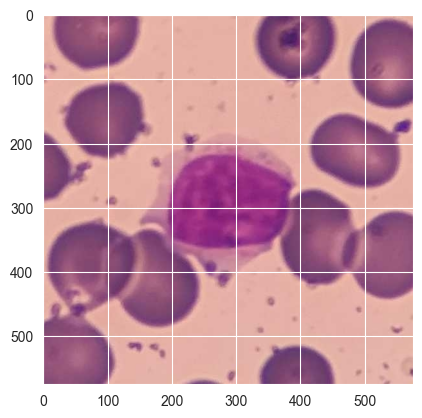

In [387]:
# making sure the image is the same after
plt.imshow(tensor_img.permute(1, 2, 0)) # use permute() to fix the order of dimensions

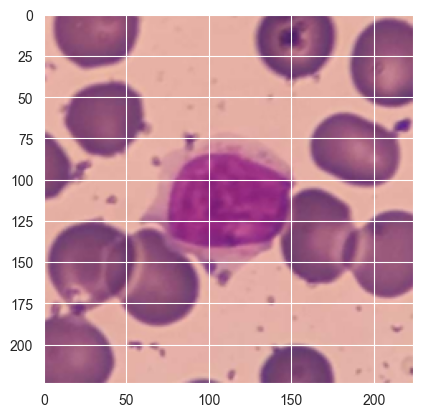

In [388]:
# practicing resizing image
resizer = transforms.Resize(size=(224, 224))
resized_img = resizer(tensor_img)
plt.imshow(resized_img.permute(1, 2, 0))

In [389]:
# transformations for training data
train_transform = v2.Compose([
    v2.Resize(size=(224, 224)),  # specs for imagenet
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomResizedCrop(size=(224, 224), scale=(0.75, 1.0)), # scale --> lower and upper bounds of crop size
    v2.ToDtype(torch.float32, scale=True), # convert to float tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406],  # also specs for imagenet
    std=[0.229, 0.224, 0.225])
    ])

# sometimes RandomResizeCrop moves the cell out of frame, may cause a problem for some samples

# transformations for test (and validation) data
test_transform = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])
    ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.545518..2.0262866].


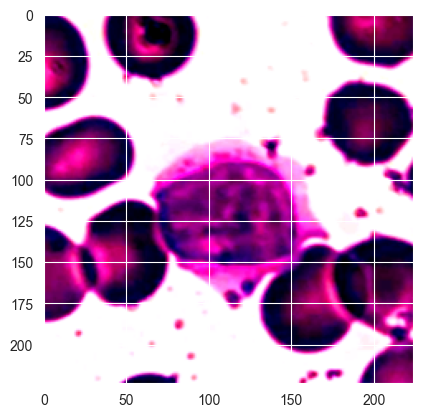

In [390]:
plt.imshow(train_transform(tensor_img).permute((1, 2, 0)))

In [391]:
# custom pytorch dataset

class ImmuneCellImageDataset(Dataset):
    def __init__(self, img_paths: list, class_labels: torch.tensor, transform=None, device=torch.device('cpu')):
        self.img_paths=img_paths
        self.class_labels = class_labels
        self.transform=transform
        self.device = device
        self.unique_labels=torch.unique(class_labels)

        if len(img_paths) != class_labels.shape[0]:
            raise ValueError(f"Number of images ({len(img_paths)}) does not equal number of class labels ({class_labels.shape[0]})")
        
    def __getitem__(self, idx):
        # get image path with index
        img_path = self.img_paths[idx]

        # read image as tensor
        img_as_tensor = read_image(img_path)
        assert self.transform is not None, "Error: must specify image transformation"
        img_as_tensor = self.transform(img_as_tensor)  # apply specified transformation to image
        img_as_tensor = img_as_tensor.to(self.device)  # move to given device
        
        # get image label
        img_label = self.class_labels[idx]
        img_label = img_label.to(self.device)

        return img_as_tensor, img_label

    def __len__(self):
        return len(self.img_paths)

    def show(self, idx):
        """
        shows image at given idx without transformations
        """
        
        # get image path with index
        img_path = self.img_paths[idx]

        # get image class
        img_class = img_path.split('/')[-2]
        
        # show image
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f'Cell Type: {img_class}, Idx: {idx}')

    def immune_cell_counts(self):
        cell_type_counts = {cell_type.item(): 0 for cell_type in self.unique_labels}

        for img_label in self.class_labels:
            cell_type_counts[img_label.item()] += 1

        return cell_type_counts

In [392]:
# creating label tensors
class_names = ['Basophil', 'Neutrophil', 'Monocyte', 'Eosinophil', 'Lymphocyte']

class_map = {}
for i, class_name in enumerate(class_names):
    class_map[class_name] = i

# maps cell types to target tensors
class_map

{'Basophil': 0,
 'Neutrophil': 1,
 'Monocyte': 2,
 'Eosinophil': 3,
 'Lymphocyte': 4}

In [393]:
# invert class mapping, for future use?
class_map_inv = {v: k for k, v in class_map.items()}
class_map_inv

{0: 'Basophil',
 1: 'Neutrophil',
 2: 'Monocyte',
 3: 'Eosinophil',
 4: 'Lymphocyte'}

In [394]:
# setting device to gpu if available
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='mps')

In [395]:
# obtain all image paths
all_img_paths = []
for directory in data_subdirects:
    all_subdirect_paths = [os.path.join(directory, subdirect_path) for subdirect_path in os.listdir(directory)]
    all_img_paths.extend(all_subdirect_paths)

len(all_img_paths)

16633

In [396]:
# obtain all class labels as tensor
class_labels = torch.tensor([class_map[filename.split('/')[-2]] for filename in all_img_paths])

len(class_labels), len(torch.unique(class_labels))

(16633, 5)

In [397]:
# split image paths and class labels into train, valid, test sets using a stratified split
train_valid_img_paths, test_img_paths, train_valid_class_labels, test_class_labels =\
train_test_split(all_img_paths, class_labels, test_size=OPTIONS['test_split_percentage'], random_state=OPTIONS['random_seed'], stratify=class_labels)

adjusted_val_split_percentage = OPTIONS['valid_split_percentage'] / (OPTIONS['train_split_percentage'] + OPTIONS['valid_split_percentage'])

train_img_paths, valid_img_paths, train_class_labels, valid_class_labels =\
train_test_split(train_valid_img_paths, train_valid_class_labels, test_size=adjusted_val_split_percentage, random_state=OPTIONS['random_seed'], stratify=train_valid_class_labels)

In [398]:
# create dataset objects
train_dataset = ImmuneCellImageDataset(img_paths=train_img_paths, class_labels=train_class_labels, transform=train_transform, device=device)
validation_dataset = ImmuneCellImageDataset(img_paths=valid_img_paths, class_labels=valid_class_labels, transform=test_transform, device=device)
test_dataset = ImmuneCellImageDataset(img_paths=test_img_paths, class_labels=test_class_labels, transform=test_transform, device=device)

In [399]:
del all_img_paths

In [400]:
# verifying image transformations applied correctly 
[data.transform for data in [train_dataset, validation_dataset, test_dataset]]

[Compose(
       Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
       RandomHorizontalFlip(p=0.5)
       RandomResizedCrop(size=(224, 224), scale=(0.75, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
       ToDtype(scale=True)
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
 ),
 Compose(
       Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
       ToDtype(scale=True)
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
 ),
 Compose(
       Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
       ToDtype(scale=True)
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
 )]

In [401]:
# checking devices 
[dataset.device for dataset in [train_dataset, validation_dataset, test_dataset]]

[device(type='mps'), device(type='mps'), device(type='mps')]

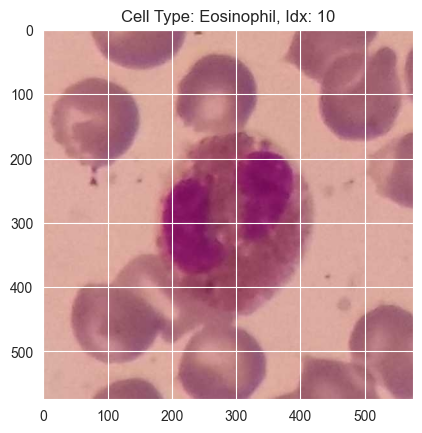

In [402]:
# viewing an image
train_dataset.show(10)

In [403]:
# checking immune cell counts for train, validation, and test data
[train_dataset.immune_cell_counts(), validation_dataset.immune_cell_counts(), test_dataset.immune_cell_counts()]

[{0: 226, 1: 8146, 2: 597, 3: 799, 4: 2706},
 {0: 45, 1: 1629, 2: 119, 3: 160, 4: 542},
 {0: 30, 1: 1087, 2: 79, 3: 107, 4: 361}]

In [404]:
# creating dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=OPTIONS['batch_size'], shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=OPTIONS['batch_size'], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=OPTIONS['batch_size'], shuffle=True)
# for some reason increasing num_workers breaks this. Seems to be a problem with using jupyter for multiprocessing, might be 
# fixed by moving to script

In [405]:
# number of batches in train, validation, and test datasets
[len(train_dataloader), len(validation_dataloader), len(test_dataloader)]

[390, 78, 52]

# Initializing Model (ResNet18)

In [406]:
import torchvision.models as models
import torch.nn as nn

In [407]:
# import resnet18 with default pretrained weights
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [408]:
# replacing resnet18 fc with custom linear layer with 5 classes. Output will be raw logits
resnet18.fc = nn.Linear(512, 5)

In [409]:
# move to specified device
resnet18 = resnet18.to(device)

In [410]:
# making sure gradients flow through the entire model
for parameter in resnet18.parameters():
    parameter.requires_grad = True
    assert parameter.requires_grad == True

# Defining Training, Validation, and Testing

In [411]:
import numpy as np

In [412]:
# hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet18.parameters(), lr=OPTIONS['learning_rate'], weight_decay=OPTIONS['l2_penalty'])

In [413]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, device):
    # set model to train mode
    model.train()
    
    running_loss = 0.
    last_loss = 0.
    
    for batch_idx, batch in enumerate(iter(dataloader)):
        # Every data instance is an input + label pair
        batch_inputs, batch_labels = batch

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        batch_outputs = model(batch_inputs)

        # Compute the loss and its gradients
        loss = loss_fn(batch_outputs, batch_labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        num_batches_per_update = 50  # number of batches for each print statement
        
        if batch_idx % num_batches_per_update == 0 and not batch_idx == 0:
            last_loss = running_loss / num_batches_per_update # loss per batch
            print(f'Batch {batch_idx} loss: {last_loss}')
            running_loss = 0.

    return last_loss

In [414]:
def validate_classification_model(dataloader, model, loss_fn, device):
    # set model to evaluation mode
    model.eval()
    
    batch_loss = 0
    batch_loss_list = []

    unique_labels = dataloader.dataset.unique_labels
    losses_for_unique_labels_raw = {unique_label.item(): [] for unique_label in unique_labels}
    
    for batch in tqdm(iter(dataloader)):
        # Every data instance is an input + label pair
        batch_inputs, batch_labels = batch

        # Make predictions for this batch
        batch_outputs = model(batch_inputs).detach()
        
        # Compute the loss
        loss = loss_fn(batch_outputs, batch_labels)

        # get loss for each label
        for unique_label in unique_labels:
            if any(batch_labels == unique_label):
                batch_idxs_for_unique_label = batch_labels == unique_label
                
                batch_outputs_for_unique_label = batch_outputs[batch_idxs_for_unique_label]
                num_samples_in_batch = len(batch_outputs_for_unique_label)
                batch_targets_for_unique_label = unique_label.repeat(1, num_samples_in_batch).flatten().to(device)
               
                loss_for_unique_label = loss_fn(batch_outputs_for_unique_label, batch_targets_for_unique_label)
                loss_for_unique_label = loss_for_unique_label.item()
            else:
                loss_for_unique_label = 0
                num_samples_in_batch = 0
                
            losses_for_unique_labels_raw[unique_label.item()].append((loss_for_unique_label, num_samples_in_batch))
        
        # Extract batch loss as float
        batch_loss = loss.item()

        # add batch loss to running list
        batch_loss_list.append(batch_loss) 

    losses_for_unique_labels = {unique_label.item(): [] for unique_label in unique_labels}

    # obtain losses for each class by aggregating individual batch losses
    for unique_label in unique_labels:
        loss_list_for_unique_label_raw = losses_for_unique_labels_raw[unique_label.item()]
        total_samples = sum([pair[1] for pair in loss_list_for_unique_label_raw])
        loss_weights = [pair[1]/total_samples for pair in loss_list_for_unique_label_raw]
        assert sum(loss_weights) == 1 
        weighted_losses = [pair[0] * loss_weights[i] for i, pair in enumerate(loss_list_for_unique_label_raw)]
        aggregated_class_loss = sum(weighted_losses)
        losses_for_unique_labels[unique_label.item()] = aggregated_class_loss

    mean_validation_loss = np.mean(batch_loss_list)
    return mean_validation_loss, losses_for_unique_labels

In [415]:
train_dataloader.dataset.unique_labels.tolist()

[0, 1, 2, 3, 4]

In [416]:
all_train_loss = []
all_validation_loss = []
all_class_validation_losses = {label: [] for label in list(class_map.values())}
all_model_paths = []
all_model_filenames = []

for epoch in range(1, OPTIONS['num_epochs']+1):
    print("-"*60)
    print("Epoch ", epoch)

    # train
    print("Starting Model Training...")
    last_train_loss = train_one_epoch(train_dataloader, resnet18, loss_fn, optimizer, device)
    print("Last train loss: ", last_train_loss)

    all_train_loss.append(last_train_loss)

    # validation
    print("Starting Model Validation...")
    mean_validation_loss, losses_for_unique_labels = validate_classification_model(validation_dataloader, resnet18, loss_fn, device)
    print("Mean validation loss: ", mean_validation_loss)

    print("Losses for individual classes: ")

    for label, loss_val in losses_for_unique_labels.items():
        print(f"\t{label}: {loss_val}")

    all_validation_loss.append(mean_validation_loss)

    # record individual class labels
    for label in losses_for_unique_labels:
        all_class_validation_losses[label].append(losses_for_unique_labels[label]) # this is stupid, I know

    # saving model
    print("Saving model...")
    model_name = f'resnet18_epoch_{epoch}.pt'
    model_path = os.path.join(OPTIONS['model_dir'], model_name)
    torch.save(resnet18, model_path) # not saving state_dict because the C++ frontend doesn't like it

    all_model_filenames.append(model_path)
    assert os.path.exists(model_path), 'Model failed to save'
    print("Model saved")

------------------------------------------------------------
Epoch  1
Starting Model Training...
Batch 50 loss: 1.2637690782546998
Batch 100 loss: 0.7606765043735504
Batch 150 loss: 0.4544829159975052
Batch 200 loss: 0.32751387000083926
Batch 250 loss: 0.2640916319191456
Batch 300 loss: 0.21573044314980508
Batch 350 loss: 0.1794522938132286
Last train loss:  0.1794522938132286
Starting Model Validation...


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


Mean validation loss:  0.13586460899275082
Losses for individual classes: 
	0: 0.12633613232109284
	1: 0.044166600479166374
	2: 0.5308063787196865
	3: 0.6887852218700573
	4: 0.16251050053349939
Saving model...
Model saved
------------------------------------------------------------
Epoch  2
Starting Model Training...
Batch 50 loss: 0.1522547796368599
Batch 100 loss: 0.13807679921388627
Batch 150 loss: 0.12852717645466327
Batch 200 loss: 0.11291949786245822
Batch 250 loss: 0.10738519418984652
Batch 300 loss: 0.0906579339876771
Batch 350 loss: 0.09926150411367417
Last train loss:  0.09926150411367417
Starting Model Validation...


100%|██████████| 78/78 [00:17<00:00,  4.42it/s]


Mean validation loss:  0.06814733040160857
Losses for individual classes: 
	0: 0.03517887054735588
	1: 0.031245834071776887
	2: 0.3077078033933228
	3: 0.2760035500796221
	4: 0.06783076258448409
Saving model...
Model saved
------------------------------------------------------------
Epoch  3
Starting Model Training...
Batch 50 loss: 0.08406416919082403
Batch 100 loss: 0.07294023452326655
Batch 150 loss: 0.06911271207034587
Batch 200 loss: 0.07556549513712525
Batch 250 loss: 0.09608403300866485
Batch 300 loss: 0.08006384763866663
Batch 350 loss: 0.07872575709596276
Last train loss:  0.07872575709596276
Starting Model Validation...


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Mean validation loss:  0.056168757940236576
Losses for individual classes: 
	0: 0.008061769853035609
	1: 0.02140782168306561
	2: 0.2078083666232747
	3: 0.2984171664036694
	4: 0.05988740989237309
Saving model...
Model saved
------------------------------------------------------------
Epoch  4
Starting Model Training...
Batch 50 loss: 0.06845786994323134
Batch 100 loss: 0.05646275544539094
Batch 150 loss: 0.05885032832622528
Batch 200 loss: 0.05589813083410263
Batch 250 loss: 0.061406252719461915
Batch 300 loss: 0.059327734950929883
Batch 350 loss: 0.05999393950216472
Last train loss:  0.05999393950216472
Starting Model Validation...


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


Mean validation loss:  0.042840870580850884
Losses for individual classes: 
	0: 0.011738751830610758
	1: 0.0184126118860654
	2: 0.2176364093591917
	3: 0.16616638896375663
	4: 0.044087274841589655
Saving model...
Model saved
------------------------------------------------------------
Epoch  5
Starting Model Training...
Batch 50 loss: 0.04524118114262819
Batch 100 loss: 0.04487002689391375
Batch 150 loss: 0.05184790133498609
Batch 200 loss: 0.049040544871240856
Batch 250 loss: 0.04920547913759947
Batch 300 loss: 0.04219856553710997
Batch 350 loss: 0.03902013640850782
Last train loss:  0.03902013640850782
Starting Model Validation...


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


Mean validation loss:  0.03844488640793432
Losses for individual classes: 
	0: 0.005855329022354757
	1: 0.015346874467350493
	2: 0.19804815577877247
	3: 0.1449225047438631
	4: 0.04413673793832596
Saving model...
Model saved
------------------------------------------------------------
Epoch  6
Starting Model Training...
Batch 50 loss: 0.03550671938806772
Batch 100 loss: 0.0382466258853674
Batch 150 loss: 0.03821368208155036
Batch 200 loss: 0.038359505478292706
Batch 250 loss: 0.03356313525699079
Batch 300 loss: 0.03176379842683673
Batch 350 loss: 0.028697745176032186
Last train loss:  0.028697745176032186
Starting Model Validation...


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


Mean validation loss:  0.03402977589613352
Losses for individual classes: 
	0: 0.004507006404229389
	1: 0.013081989437598961
	2: 0.17531005303084873
	3: 0.10050620497927412
	4: 0.04875959613159852
Saving model...
Model saved
------------------------------------------------------------
Epoch  7
Starting Model Training...
Batch 50 loss: 0.02778505500406027
Batch 100 loss: 0.030662467684596777
Batch 150 loss: 0.030267300996929408
Batch 200 loss: 0.02877685392741114
Batch 250 loss: 0.02516064293216914
Batch 300 loss: 0.03478773280512541
Batch 350 loss: 0.032033652560785414
Last train loss:  0.032033652560785414
Starting Model Validation...


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Mean validation loss:  0.03187730122142686
Losses for individual classes: 
	0: 0.0017527327844517357
	1: 0.014442298130690822
	2: 0.1867760766502773
	3: 0.0719359508768207
	4: 0.040891160355426365
Saving model...
Model saved
------------------------------------------------------------
Epoch  8
Starting Model Training...
Batch 50 loss: 0.02298160026781261
Batch 100 loss: 0.03132671302184462
Batch 150 loss: 0.028310279818251727
Batch 200 loss: 0.049354807189665735
Batch 250 loss: 0.03296334854792803
Batch 300 loss: 0.02627850801218301
Batch 350 loss: 0.0232392357615754
Last train loss:  0.0232392357615754
Starting Model Validation...


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


Mean validation loss:  0.03114503891004297
Losses for individual classes: 
	0: 0.003119567753472236
	1: 0.012116264426601082
	2: 0.1208258756403574
	3: 0.09309992480972369
	4: 0.05273513735647441
Saving model...
Model saved
------------------------------------------------------------
Epoch  9
Starting Model Training...
Batch 50 loss: 0.029830955294892193
Batch 100 loss: 0.028259555799886583
Batch 150 loss: 0.023015492875128985
Batch 200 loss: 0.01940961552085355
Batch 250 loss: 0.020838604427408428
Batch 300 loss: 0.019562027296051384
Batch 350 loss: 0.020321927317418158
Last train loss:  0.020321927317418158
Starting Model Validation...


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


Mean validation loss:  0.032742316160016716
Losses for individual classes: 
	0: 0.0028079332610812142
	1: 0.00989039599331767
	2: 0.25185857908951875
	3: 0.08080190643688638
	4: 0.04165568619909481
Saving model...
Model saved
------------------------------------------------------------
Epoch  10
Starting Model Training...
Batch 50 loss: 0.02021743183489889
Batch 100 loss: 0.01938169213011861
Batch 150 loss: 0.01856785414274782
Batch 200 loss: 0.020803775880485775
Batch 250 loss: 0.018131682900711894
Batch 300 loss: 0.021177053744904698
Batch 350 loss: 0.016819235703442247
Last train loss:  0.016819235703442247
Starting Model Validation...


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


Mean validation loss:  0.031906360308102406
Losses for individual classes: 
	0: 0.0024321735286018035
	1: 0.01319543778913626
	2: 0.2983809203098889
	3: 0.05908225617751555
	4: 0.02411343113058423
Saving model...
Model saved
------------------------------------------------------------
Epoch  11
Starting Model Training...
Batch 50 loss: 0.013755758563056587
Batch 100 loss: 0.01624918537447229
Batch 150 loss: 0.015680561133194715
Batch 200 loss: 0.0173306701797992
Batch 250 loss: 0.014660474557895214
Batch 300 loss: 0.02947012779302895
Batch 350 loss: 0.016214705449528993
Last train loss:  0.016214705449528993
Starting Model Validation...


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


Mean validation loss:  0.030561461966359414
Losses for individual classes: 
	0: 0.0013891164549932002
	1: 0.01085588510939051
	2: 0.22268005752407244
	3: 0.09010906110105453
	4: 0.03227554214924979
Saving model...
Model saved
------------------------------------------------------------
Epoch  12
Starting Model Training...
Batch 50 loss: 0.008936319982167333
Batch 100 loss: 0.014940776084549724
Batch 150 loss: 0.009592761917738245
Batch 200 loss: 0.017812372888438403
Batch 250 loss: 0.012234265017323196
Batch 300 loss: 0.012459889982128516
Batch 350 loss: 0.012541051174048334
Last train loss:  0.012541051174048334
Starting Model Validation...


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


Mean validation loss:  0.03195815062290654
Losses for individual classes: 
	0: 0.0017635122216334922
	1: 0.015781876005697137
	2: 0.30566828262262713
	3: 0.05076833189892227
	4: 0.017491301956095318
Saving model...
Model saved
------------------------------------------------------------
Epoch  13
Starting Model Training...
Batch 50 loss: 0.01685706215677783
Batch 100 loss: 0.012624380423221736
Batch 150 loss: 0.014590880032628775
Batch 200 loss: 0.014023916822625325
Batch 250 loss: 0.02165038790786639
Batch 300 loss: 0.009165396878961474
Batch 350 loss: 0.01216271982411854
Last train loss:  0.01216271982411854
Starting Model Validation...


100%|██████████| 78/78 [00:17<00:00,  4.52it/s]


Mean validation loss:  0.029102326167048886
Losses for individual classes: 
	0: 0.002880655336768238
	1: 0.01061462948978933
	2: 0.09697355285831744
	3: 0.059402497583948846
	4: 0.06293912050444732
Saving model...
Model saved
------------------------------------------------------------
Epoch  14
Starting Model Training...
Batch 50 loss: 0.015016714551020414
Batch 100 loss: 0.016895762535277754
Batch 150 loss: 0.009886523523600772
Batch 200 loss: 0.01187375521636568
Batch 250 loss: 0.0159530726831872
Batch 300 loss: 0.010036280816420913
Batch 350 loss: 0.007469193625729531
Last train loss:  0.007469193625729531
Starting Model Validation...


100%|██████████| 78/78 [00:17<00:00,  4.53it/s]


Mean validation loss:  0.03098884287651461
Losses for individual classes: 
	0: 0.0011228437886024443
	1: 0.012672701206175752
	2: 0.09069313104241739
	3: 0.09895391299178301
	4: 0.05540141014049751
Saving model...
Model saved
------------------------------------------------------------
Epoch  15
Starting Model Training...
Batch 50 loss: 0.007363790470408276
Batch 100 loss: 0.00960715693421662
Batch 150 loss: 0.00954219683771953
Batch 200 loss: 0.009186485977843405
Batch 250 loss: 0.006905677171889692
Batch 300 loss: 0.011123734157299623
Batch 350 loss: 0.006778369008097798
Last train loss:  0.006778369008097798
Starting Model Validation...


100%|██████████| 78/78 [00:17<00:00,  4.56it/s]


Mean validation loss:  0.03200093660733472
Losses for individual classes: 
	0: 0.0017273435871970834
	1: 0.010719206904723184
	2: 0.2813416027361123
	3: 0.056900290809576815
	4: 0.03643737182442556
Saving model...
Model saved
------------------------------------------------------------
Epoch  16
Starting Model Training...
Batch 50 loss: 0.010448955245083198
Batch 100 loss: 0.009057015621801839
Batch 150 loss: 0.009431474277516828
Batch 200 loss: 0.009034065688028932
Batch 250 loss: 0.008325348088983447
Batch 300 loss: 0.016459000726463273
Batch 350 loss: 0.01206223686109297
Last train loss:  0.01206223686109297
Starting Model Validation...


100%|██████████| 78/78 [00:17<00:00,  4.58it/s]


Mean validation loss:  0.03163454015604937
Losses for individual classes: 
	0: 0.002442337845670611
	1: 0.011463183602322456
	2: 0.29349403717069894
	3: 0.06378086184059839
	4: 0.027755602789763318
Saving model...
Model saved
------------------------------------------------------------
Epoch  17
Starting Model Training...
Batch 50 loss: 0.010869412129977718
Batch 100 loss: 0.0077289165020920335
Batch 150 loss: 0.009771973825991154
Batch 200 loss: 0.008951687837252394
Batch 250 loss: 0.004409228548756801
Batch 300 loss: 0.004591472761239857
Batch 350 loss: 0.004438340745400638
Last train loss:  0.004438340745400638
Starting Model Validation...


100%|██████████| 78/78 [00:17<00:00,  4.48it/s]


Mean validation loss:  0.027855572071320448
Losses for individual classes: 
	0: 0.0011176178971027185
	1: 0.01133103234528111
	2: 0.11679901689549028
	3: 0.054105364555466905
	4: 0.052510013900172285
Saving model...
Model saved
------------------------------------------------------------
Epoch  18
Starting Model Training...
Batch 50 loss: 0.009286293600453063
Batch 100 loss: 0.0069145693734753875
Batch 150 loss: 0.009595519494032487
Batch 200 loss: 0.006949841068126262
Batch 250 loss: 0.006698422119370662
Batch 300 loss: 0.00479305194108747
Batch 350 loss: 0.0038550366077106444
Last train loss:  0.0038550366077106444
Starting Model Validation...


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


Mean validation loss:  0.0297746754255898
Losses for individual classes: 
	0: 0.00035715121110797555
	1: 0.010992770701968538
	2: 0.1900004431153962
	3: 0.0837806414831789
	4: 0.036996284249240605
Saving model...
Model saved
------------------------------------------------------------
Epoch  19
Starting Model Training...
Batch 50 loss: 0.009165574514772743
Batch 100 loss: 0.007409527041018009
Batch 150 loss: 0.012761716818786226
Batch 200 loss: 0.006391282450640574
Batch 250 loss: 0.004473339833784848
Batch 300 loss: 0.008330432104412467
Batch 350 loss: 0.006341267200186848
Last train loss:  0.006341267200186848
Starting Model Validation...


100%|██████████| 78/78 [00:17<00:00,  4.45it/s]


Mean validation loss:  0.03201400365558071
Losses for individual classes: 
	0: 0.0003223367343682387
	1: 0.012794195778456464
	2: 0.22955158560454542
	3: 0.06645212340830682
	4: 0.038921893663823925
Saving model...
Model saved
------------------------------------------------------------
Epoch  20
Starting Model Training...
Batch 50 loss: 0.003694285095552914
Batch 100 loss: 0.0033154960750835017
Batch 150 loss: 0.010179197324905544
Batch 200 loss: 0.004294989620684646
Batch 250 loss: 0.003936485276790335
Batch 300 loss: 0.00523251221748069
Batch 350 loss: 0.0047948232380440456
Last train loss:  0.0047948232380440456
Starting Model Validation...


100%|██████████| 78/78 [00:16<00:00,  4.63it/s]


Mean validation loss:  0.03569464590243744
Losses for individual classes: 
	0: 0.0008006396805632853
	1: 0.013027445800830264
	2: 0.24124986882580546
	3: 0.10635667208494085
	4: 0.04072379255882386
Saving model...
Model saved
------------------------------------------------------------
Epoch  21
Starting Model Training...
Batch 50 loss: 0.0027258973522111775
Batch 100 loss: 0.003998462105519138
Batch 150 loss: 0.005801988382590935
Batch 200 loss: 0.0072913986400817525
Batch 250 loss: 0.006133384507265873
Batch 300 loss: 0.005101517912407871
Batch 350 loss: 0.006038127515930683
Last train loss:  0.006038127515930683
Starting Model Validation...


100%|██████████| 78/78 [00:17<00:00,  4.58it/s]


Mean validation loss:  0.033564439080715276
Losses for individual classes: 
	0: 0.0003981232511819144
	1: 0.011747709024803881
	2: 0.2257349637184363
	3: 0.09104865109281378
	4: 0.042787039552821725
Saving model...
Model saved
------------------------------------------------------------
Epoch  22
Starting Model Training...
Batch 50 loss: 0.0026537910223123616
Batch 100 loss: 0.0058723919451585975
Batch 150 loss: 0.005084663826273754
Batch 200 loss: 0.0051874311515712175
Batch 250 loss: 0.003893136807892006
Batch 300 loss: 0.006749766689026728
Batch 350 loss: 0.006232380214496516
Last train loss:  0.006232380214496516
Starting Model Validation...


100%|██████████| 78/78 [00:16<00:00,  4.71it/s]


Mean validation loss:  0.034308272057200946
Losses for individual classes: 
	0: 0.00019907115752096791
	1: 0.010432567361729322
	2: 0.11316197168156057
	3: 0.11273268076933506
	4: 0.06849778761916844
Saving model...
Model saved
------------------------------------------------------------
Epoch  23
Starting Model Training...
Batch 50 loss: 0.006693964663427323
Batch 100 loss: 0.0035850225860485805
Batch 150 loss: 0.003032749580452219
Batch 200 loss: 0.0030646322370739654
Batch 250 loss: 0.0036701716034440324
Batch 300 loss: 0.008575633403961547
Batch 350 loss: 0.004123288420087193
Last train loss:  0.004123288420087193
Starting Model Validation...


100%|██████████| 78/78 [00:16<00:00,  4.71it/s]


Mean validation loss:  0.03202619271887203
Losses for individual classes: 
	0: 7.086287948128402e-05
	1: 0.010544120357171767
	2: 0.3209649452989146
	3: 0.04414489613537
	4: 0.03228682286341888
Saving model...
Model saved
------------------------------------------------------------
Epoch  24
Starting Model Training...
Batch 50 loss: 0.0071016452740877865
Batch 100 loss: 0.004496692927205004
Batch 150 loss: 0.00572986131941434
Batch 200 loss: 0.003626676281564869
Batch 250 loss: 0.00250351565919118
Batch 300 loss: 0.0019959842920070515
Batch 350 loss: 0.0028801865171408283
Last train loss:  0.0028801865171408283
Starting Model Validation...


100%|██████████| 78/78 [00:16<00:00,  4.63it/s]


Mean validation loss:  0.03564049224055802
Losses for individual classes: 
	0: 0.00016688988218002503
	1: 0.014060451200548068
	2: 0.30472639622787157
	3: 0.06177818181811859
	4: 0.0365756663484254
Saving model...
Model saved
------------------------------------------------------------
Epoch  25
Starting Model Training...
Batch 50 loss: 0.002574149193242192
Batch 100 loss: 0.001866111533017829
Batch 150 loss: 0.0016728210897417738
Batch 200 loss: 0.0027622841668198815
Batch 250 loss: 0.0012660504310042597
Batch 300 loss: 0.0022088058138615453
Batch 350 loss: 0.002279226256359834
Last train loss:  0.002279226256359834
Starting Model Validation...


100%|██████████| 78/78 [00:16<00:00,  4.69it/s]

Mean validation loss:  0.03460652754326405
Losses for individual classes: 
	0: 0.00011612448516807996
	1: 0.014207261815065996
	2: 0.22388784088642552
	3: 0.0956267904639617
	4: 0.03927204501314918
Saving model...
Model saved


In [417]:
# test
print("Starting Model Test...")
test_loss, losses_for_unique_labels = validate_classification_model(test_dataloader, resnet18, loss_fn, device)
print("Test loss: ", test_loss)
print(f"Losses for individual classes: {losses_for_unique_labels}")

Starting Model Test...


100%|██████████| 52/52 [00:11<00:00,  4.41it/s]

Test loss:  0.04173904611693265
Losses for individual classes: {0: 6.391783038660985e-05, 1: 0.005318156487700742, 2: 0.28954319444425625, 3: 0.2176981190591462, 4: 0.04848590107092735}


# Evaluating Model

In [418]:
import seaborn as sns
import pandas as pd
import numpy as np

from tqdm import tqdm

In [431]:
df_train_val_loss = pd.DataFrame({
    # 'epoch': np.arange(1, OPTIONS['num_epochs']+1),
    'Train': all_train_loss,
    'Validation': all_validation_loss
})

df_classes = pd.DataFrame({class_map_inv[label]: all_class_validation_losses[label] for label in all_class_validation_losses})

all_loss_df = pd.concat([df_train_val_loss, df_classes], axis=1)

all_loss_df.head()

,Train,Validation,Basophil,Neutrophil,Monocyte,Eosinophil,Lymphocyte
0,0.179452,0.135865,0.126336,0.044167,0.530806,0.688785,0.162511
1,0.099262,0.068147,0.035179,0.031246,0.307708,0.276004,0.067831
2,0.078726,0.056169,0.008062,0.021408,0.207808,0.298417,0.059887
3,0.059994,0.042841,0.011739,0.018413,0.217636,0.166166,0.044087
4,0.039020,0.038445,0.005855,0.015347,0.198048,0.144923,0.044137


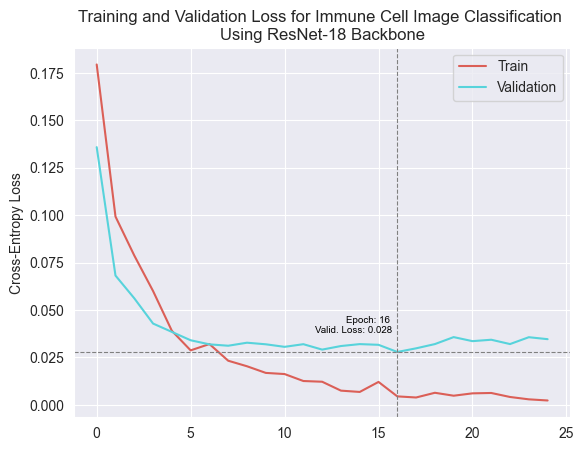

In [441]:
sns.set_style("darkgrid")
sns.lineplot(data=all_loss_df[['Train', 'Validation']], palette='hls', dashes=False)
plt.ylabel('Cross-Entropy Loss')
plt.title('Training and Validation Loss for Immune Cell Image Classification \nUsing ResNet-18 Backbone')

plt.axvline(x=np.argmin(all_loss_df.Validation), color='gray', linestyle='--', linewidth='0.8')
plt.axhline(y=np.min(all_loss_df.Validation), color='gray', linestyle='--', linewidth='0.8')
plt.text(x=np.argmin(all_loss_df.Validation)-.25, y=np.min(all_loss_df.Validation)+0.01, 
         s=f"Epoch: {np.argmin(all_loss_df.Validation)} \nValid. Loss: {round(np.min(all_loss_df.Validation), 3)}", 
         color='black', fontsize=7, ha='right')

filename_train_and_valid=f"plots/Train_and_Validation_Loss_for_Immune_Cell_Image_Classification_Using_Transfer_Learning_on_Resnet_18_{neattime()}.png"
plt.savefig(fname=filename_train_and_valid, dpi=1000)

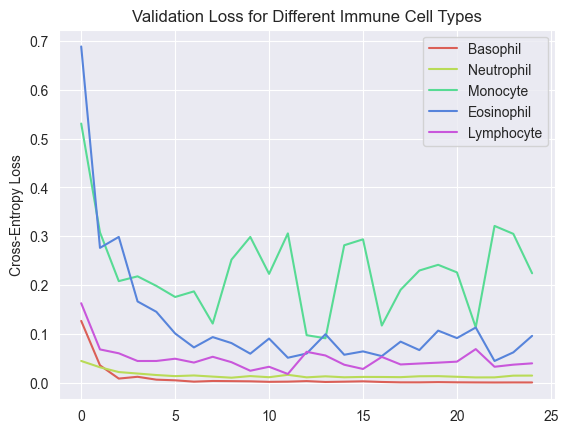

In [440]:
sns.set_style("darkgrid")
sns.lineplot(data=all_loss_df[['Basophil', 'Neutrophil', 'Monocyte', 'Eosinophil', 'Lymphocyte']], palette='hls', dashes=False)
plt.ylabel('Cross-Entropy Loss')
plt.title('Validation Loss for Different Immune Cell Types')
filename_diff_immune_cell=f"plots/Validation_Loss_for_Each_Immune_Cell_Type_{neattime()}"
plt.savefig(fname=filename_diff_immune_cell, dpi=1000)

In [434]:
# checking out test dataset
test_dataloader.dataset.immune_cell_counts()

{0: 30, 1: 1087, 2: 79, 3: 107, 4: 361}

In [435]:
def classification_accuracy(dataloader, model):
    # set model to evaluation mode
    model.eval()

    total_correct = 0
    total_samples = len(dataloader.dataset)
    
    for batch in tqdm(iter(dataloader)):
        # Every data instance is an input + label pair
        batch_inputs, batch_labels = batch

        # Make predictions for this batch
        batch_outputs = model(batch_inputs).detach()
        
        # Obtaining model consensus
        batch_consensus = torch.argmax(batch_outputs, dim=1)
        total_correct += sum(batch_consensus == batch_labels).item() # get num targets that match consensus

    p_correct = total_correct / total_samples
    
    return p_correct

In [50]:
# best validation loss from epoch 47
model=torch.load('models/resnet18_epoch_47_time_04_06_2024_19_42_45') 

In [234]:
# accuracy on test set
classification_accuracy(test_dataloader, model)

NameError: name 'model' is not defined